# STARRED deconvolution of 2m2 DES2038 data

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from matplotlib import colors


from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss
from starred.optim.optimization import Optimizer
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.plots.plot_function import view_deconv_model

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Load data

In [2]:
# get data
with h5py.File('./data/5_data/stamps-noisemaps-psfs.h5', 'r') as f:
    data = np.array(f['stamps'])
    sigma_2 = np.array(f['noisemaps'])**2
    s = np.array(f['psfs'])

print(s.shape, data.shape, sigma_2.shape)

epochs = data.shape[0]
im_size = data[0].shape[0]
im_size_up = s[0].shape[0]
subsampling_factor = im_size_up // im_size

(31, 64, 64) (31, 32, 32) (31, 32, 32)


/tmp/ipykernel_106154/2342335483.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data = np.array(f['stamps'])
/tmp/ipykernel_106154/2342335483.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  sigma_2 = np.array(f['noisemaps'])**2
/tmp/ipykernel_106154/2342335483.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  s = np.array(f['psfs'])


## Parameter initialization

In [3]:

# image positions:
off = 33.8
xs = np.array([37.10, 27.45, 33.81, 27.92]) - off + 0.5
ys = np.array([36.19, 29.03, 29.15, 37.81]) - off + 0.5
amps = [30000., 36000., 36000., 19140.] * epochs


t0 = time()

model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data,
                                                                       sigma_2,
                                                                       s,
                                                                       xs, 
                                                                       ys, 
                                                                       subsampling_factor,
                                                                       amps)

In [4]:
#view_deconv_model(model, kwargs_init, data, sigma_2)

## Noise propagation

In [5]:
# compute noise level in starlet space
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_init, wavelet_type_list=['starlet'], 
                    method='SLIT', num_samples=200, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]


/home/users/millon/.local/lib/python3.9/site-packages/jax/_src/scipy/signal.py:78: UserWarning: convolve() ignores method argument
  warnings.warn("convolve() ignores method argument")


## Background tunning

In [6]:
# here we fix the positions and intensites of point sources,
# and only allow for the background to vary. 
# (pre-requisite: our initial guess is good, so we can just bring up the 
#  background without worrying about the point sources)
kwargs_fixed['kwargs_analytic']['c_x'] = kwargs_init['kwargs_analytic']['c_x']
kwargs_fixed['kwargs_analytic']['c_y'] = kwargs_init['kwargs_analytic']['c_y']
kwargs_fixed['kwargs_analytic']['a'] = kwargs_init['kwargs_analytic']['a']

parameters = ParametersDeconv(kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1., 
            regularization_strength_hf=1., W=W) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':3000, 'min_iterations':None,
                            'init_learning_rate':1e-2, 'schedule_learning_rate':True,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)


kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))


optax.adabelief: 100%|██████████| 3000/3000 [00:10<00:00, 279.48it/s]


In [7]:
#view_deconv_model(model, kwargs_partial, data, sigma_2)

## Final tuning

In [8]:
# allow everything to be optimized at once.
kwargs_fixed = {
    'kwargs_analytic': {},
    'kwargs_background': {},
    'kwargs_sersic':{}
}

parameters = ParametersDeconv(kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1, 
            regularization_strength_hf=1., W=W) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':9000, 'min_iterations':None,
                            'init_learning_rate':3e-3, 'schedule_learning_rate':False,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)



kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
# checking how the loss behaved ...
#plt.figure()
#plt.plot(extra_fields['loss_history'])
#plt.show()

optax.adabelief: 100%|██████████| 9000/9000 [00:26<00:00, 346.11it/s]


In [9]:
runtime = time()-t0
print(f"This deconvolution took {runtime:.0f} seconds.")


This deconvolution took 45 seconds.


In [10]:
#view_deconv_model(model, kwargs_final, data, sigma_2)

In [11]:
# Retrieving different elements of the deconvolved image
deconv, h = model.getDeconvolved(kwargs_final, 3)

In [18]:
import h5py
f160 = './data/5_data/data_f160w.hdf5'
ff =  h5py.File(f160,'r+')
f160im = ff['image_data']

random_im = './data/5_data/stamps-noisemaps-psfs_random.h5'
random_imff =  h5py.File(random_im,'r+')
data_rand = random_imff['stamps']

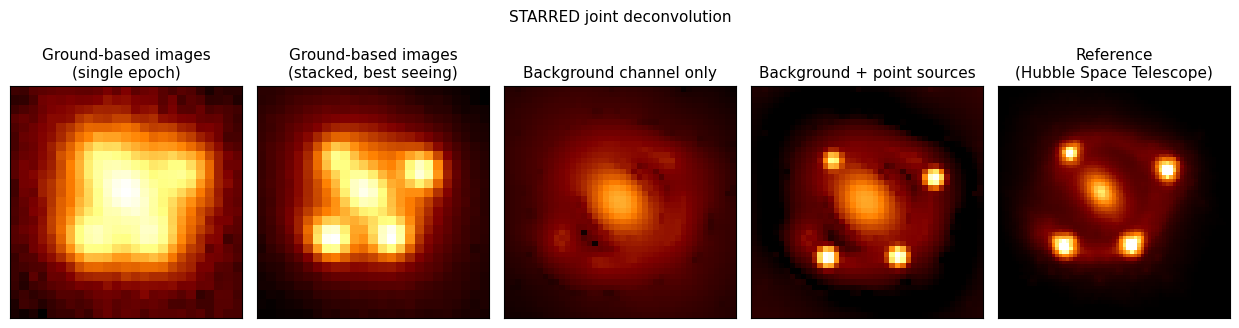

In [31]:
# cm = 'gist_stern_r'
#cm = 'RdBu_r'
#cm = 'RdBu'
#cm = 'gray'
#cm = 'Purples'
#cm = 'Greys'
cm = 'afmhot'
nimage=20
import copy

def customNorm(im, maxx=99.99, minn=20, linthresh=30, exp=0.5):
    show = np.abs(im)**exp
    vv, VV = np.nanpercentile(show, (minn,maxx))
    norm = colors.SymLogNorm(linthresh=linthresh, vmin=vv, vmax=VV)
    return show, norm


fig, axs = plt.subplots(1,5, figsize=(12.5,4.1))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
(ax0,ax1,ax2,ax3,ax4) = axs


xa, ya, WW = 3, 3, 25
dmshow, dmnorm = customNorm(copy.deepcopy(data_rand[nimage,ya:ya+WW,xa:xa+WW]), 100, 0., linthresh=200, exp=0.5)
ax0.imshow(dmshow, norm=dmnorm, origin='lower', cmap=cm)
ax0.set_title(f'Ground-based images\n(single epoch)', fontsize=11)

dm = np.mean(data,axis=0)
xa, ya, WW = 2, 3, 25
dmshow, dmnorm = customNorm(dm[ya:ya+WW,xa:xa+WW], 100, 0, linthresh=100)
ax1.imshow(dmshow, norm=dmnorm, origin='lower', cmap=cm)
ax1.set_title(f'Ground-based images\n(stacked, best seeing)', fontsize=11)


fac = subsampling_factor
xa, ya, WW = 3*fac, 6*fac, 21*fac



decshow, decnorm = customNorm(deconv[ya:ya+WW,xa:xa+WW], 
                              minn=20, maxx=99.9, linthresh=590,
                              exp=0.3)
ax3.imshow(decshow,origin='lower',norm=decnorm, cmap=cm)
ax3.set_title(f'Background + point sources', fontsize=11)



hshow, hnorm = customNorm(h[ya:ya+WW,xa:xa+WW], 
                          minn=20, maxx=99.9, linthresh=30,
                          exp=0.3)
ax2.imshow(hshow, origin='lower',norm=decnorm, cmap=cm)
ax2.set_title(f'Background channel only', fontsize=11)


ya, xa, WW = 13, 21, 65
hstshow, hstnorm = customNorm(f160im[ya:ya+WW,xa:xa+WW], maxx=99.49, exp=0.54)
ax4.imshow(hstshow,origin='lower',norm=hstnorm, cmap=cm)
ax4.set_title('Reference\n(Hubble Space Telescope)', fontsize=11)

ext = []
for j in range(4):
    ext.append([axs[j].get_window_extent().x0, axs[j].get_window_extent().width ])
inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (1.61*width_left, 1) )

plt.figtext(0.5, 0.95, "STARRED joint deconvolution", va="center", ha="center", size=11)
plt.tight_layout()
plt.savefig('./fig_joss.png', dpi=500)
plt.savefig('./fig_joss.pdf', dpi=500)
plt.show()